In [481]:
#!/usr/bin/env python

from shutil import copyfile
import subprocess
from subprocess import Popen, PIPE
from multiprocessing import Pool, freeze_support, cpu_count
import matplotlib.pyplot as plt
import itertools
import os
from glob import glob
import numpy as np
import argparse
import sys
import logging
import cv2
from copy import copy, deepcopy
from scipy.ndimage import rotate
import logging
from skimage.io import imread
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
import config
import math
from features import detect_and_extract
%load_ext autoreload
from mask import remove_empty_alpha
%autoreload 2
#from iceview.features import detect_and_extract
#from iceview.models import find_two_matches
#from iceview.mask import find_mask
#import utils
absolute_min_matches = 10
from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.transform import warp, SimilarityTransform, AffineTransform, ProjectiveTransform
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sift = cv2.SIFT()
orb = cv2.ORB()
surf = cv2.SURF()
brisk = cv2.BRISK()

In [3]:
# put stuff here that should be changed 
input_dir = 'jo_patch/' 
input_image_type = '.jpg'
output_dir = 'jo_out'
output_image_type = '.jpg'
wsize = (400,300)
lfile = os.path.join(output_dir, 'mosaic_info.txt')

In [4]:
def prepare_inout():
    in_files = glob(os.path.join(input_dir, '*%s' %input_image_type))
    logging.info("Found %d images" %len(in_files))


    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    return in_files
# should do something if there is stuff in the outputdir

In [5]:
def cvKeypointMatcher(kp1, kp2, des1, des2, match_type="BruteForce", min_ratio=0.7, reproj_thresh=4.0):
    matcher = cv2.DescriptorMatcher_create(match_type)
    """
    :reprojThresh is the maximum pixel “wiggle room” allowed by the RANSAC algorithm
     """
    # raw_matches could contain false positives
    raw_matches = matcher.knnMatch(des1, des2, 2)
    matches = []
    # loop over the raw matches to apply Lowe's ratio test to
    #determine high-quality feature matches
    for m in raw_matches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        # The reason we want the top two matches rather than just the top 
        # one match is because we need to apply David Lowe’s ratio test
        # for false-positive match pruning.
        if len(m) == 2 and m[0].distance < m[1].distance * min_ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))
            
    # computing a homography requires at least 4 matches
    if len(matches) > 4:
        # construct the two sets of points
        mat2, mat1 = zip(*matches)
        #pts1 = kp1[np.asarray(mat2)].astype(np.float32)
        #pts2 = kp2[np.asarray(mat1)].astype(np.float32)
        pts1 = np.asarray([kp1[i] for (_, i) in matches], dtype=np.float32)
        pts2 = np.asarray([kp2[i] for (i, _) in matches], dtype=np.float32)
        # compute the homography between the two sets of points
        # reprojThresh is the maximum pixel “wiggle room” allowed by the RANSAC algorithm
        (H, status) = cv2.findHomography(pts1, pts2, cv2.RANSAC, reproj_thresh)

        # return the matches along with the homograpy matrix
        # and status of each matched point
        return (matches, H, status)

    # otherwise, no homograpy could be computed
    return False

In [6]:
#from skimage.feature.util import _mask_border_keypoints, DescriptorExtractor
class zernike(DescriptorExtractor):
    
    def __init__(self, descriptor_size=256, patch_size=49,
                  sigma=1, sample_seed=1):
        self.descriptor_size = descriptor_size
        self.patch_size = patch_size
        self.sigma = sigma
        self.sample_seed = sample_seed

        self.descriptors = None
        self.mask = None
    
    def extract(self, image, keypoints):
        patch_size = self.patch_size
        desc_size = self.descriptor_size
        random = np.random.RandomState()
        random.seed(self.sample_seed)
        samples = (patch_size / 5.0) * random.randn(desc_size * 8)
        samples = np.array(samples, dtype=np.int32)
        samples = samples[(samples < (patch_size // 2))
                          & (samples > - (patch_size - 2) // 2)]

        pos1 = samples[:desc_size * 2].reshape(desc_size, 2)
        pos2 = samples[desc_size * 2:desc_size * 4].reshape(desc_size, 2)
        
        pos1 = np.ascontiguousarray(pos1)
        pos2 = np.ascontiguousarray(pos2)
        self.mask = _mask_border_keypoints(image.shape, keypoints,
                                           patch_size // 2)
        keypoints = np.array(keypoints[self.mask, :], dtype=np.intp,
                             order='C', copy=False)
        self.descriptors = np.zeros((keypoints.shape[0], desc_size),
                                    dtype=bool, order='C')
        
        _zern_loop(image, self.descriptors.view(np.uint8), keypoints,
                    pos1, pos2)
        
def _zern_loop(image, descriptors, keypoints, pos0, pos1):
    for p in range(pos0.shape[0]):
        pr0 = pos0[p, 0]
        pc0 = pos0[p, 1]
        pr1 = pos1[p, 0]
        pc1 = pos1[p, 1]
        for k in range(keypoints.shape[0]):
            kr = keypoints[k, 0]
            kc = keypoints[k, 1]
            if image[kr + pr0, kc + pc0] < image[kr + pr1, kc + pc1]:
                descriptors[k, p] = True
                from mahotas.features import zernike_moments

br1 = zernike()
#keypoints = corner_peaks(corner_harris(img1), min_distance=5)
keypoints1 = corner_peaks(corner_harris(img1, method='eps', eps=.001, sigma=3), min_distance=5)
br1.extract(img1, keypoints1)
descriptors1 = br1.descriptors
keypoints1 = keypoints1[br1.mask]

br2 = zernike()
#keypoints1 = corner_peaks(corner_harris(img2), min_distance=5)
keypoints2 = corner_peaks(corner_harris(img2, method='eps', eps=.001, sigma=3), min_distance=5)
br2.extract(img2, keypoints)
descriptors2 = br2.descriptors
keypoints2 = keypoints2[br2.mask]

NameError: name 'DescriptorExtractor' is not defined

In [ ]:
# images should be single channel and fairly small
img1 = cv2.resize(img1o, (400,300))
imgt = cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)

In [8]:
def mosaic2imgs(img1, img2, detector, do_plot=False):
    k1, d1 = getKeypointandDescriptors(img1, detector)
    k2, d2 = getKeypointandDescriptors(img2, detector)
    M =  cvKeypointMatcher(k1, k2, d1, d2, "BruteForce", 0.7, 4.0)
    return 
    if M is None:
        print("Not a match")
        return None
    else:
        # H is the 3x3 transformation matrix
        (matches, H, status) = M
        #result = cv2.warpPerspective(img1, H, (img1.shape[1] + img2.shape[1], img1.shape[0]))
        #result[0:img2.shape[0], 0:img2.shape[1]] = img2
        h1,w1 = img1.shape[:2]
        h2,w2 = img2.shape[:2]
        
        dsize = (img1.shape[0] + img2.shape[0], img1.shape[1] )
        #print(dsize)
        result = cv2.warpPerspective(img1, H, dsize)
        result[0:img2.shape[0], 0:img2.shape[1]] = img2

        #if do_plot:
        #    vis = self.drawMatches(img1, img2, k1, k2, matches, status)

        #    # return a tuple of the stitched image and the
        #    # visualization
        #    return (result, vis)

        # return the stitched image
        return result


In [10]:
def filter_matches(matches, ratio = 0.75):
    filtered_matches = []
    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            filtered_matches.append(m[0])

    return filtered_matches

def imageDistance(matches):
    sumDistance = 0.0
    for match in matches:
        sumDistance += match.distance
    return sumDistance



def findDimensions(bimg, image, H):
    H_inv = np.linalg.inv(H)
    base_p1 = np.ones(3, np.float32)
    base_p2 = np.ones(3, np.float32)
    base_p3 = np.ones(3, np.float32)
    base_p4 = np.ones(3, np.float32)

    (y, x) = image.shape[:2]

    base_p1[:2] = [0,0]
    base_p2[:2] = [x,0]
    base_p3[:2] = [0,y]
    base_p4[:2] = [x,y]

    max_x = None
    max_y = None
    min_x = None
    min_y = None

    for pt in [base_p1, base_p2, base_p3, base_p4]:
        hp = np.matrix(H_inv, np.float32) * np.matrix(pt, np.float32).T
        hp_arr = np.array(hp, np.float32)
        normal_pt = np.array([hp_arr[0]/hp_arr[2], hp_arr[1]/hp_arr[2]], np.float32)
        if ( max_x == None or normal_pt[0,0] > max_x ):
            max_x = normal_pt[0,0]
        if ( max_y == None or normal_pt[1,0] > max_y ):
            max_y = normal_pt[1,0]
        if ( min_x == None or normal_pt[0,0] < min_x ):
            min_x = normal_pt[0,0]
        if ( min_y == None or normal_pt[1,0] < min_y ):
            min_y = normal_pt[1,0]

    min_x = min(0, min_x)
    min_y = min(0, min_y)
    
    max_x = max(max_x, bimg.shape[1]+1)
    max_y = max(max_y, bimg.shape[0]+1)

    move_h = np.matrix(np.identity(3), np.float32)

    if ( min_x < 0 ):
        move_h[0,2] += -min_x
        max_x += -min_x

    if ( min_y < 0 ):
        move_h[1,2] += -min_y
        max_y += -min_y

    mod_inv_h = move_h * H_inv

    return min_x, min_y, max_x, max_y, move_h, mod_inv_h




In [18]:
class AlignImagesRansac(object):
 
    def __init__(self, input_dir, output_dir, img_type='.jpg'):
        '''
        image_dir: 'directory' containing all images
        key_frame: 'dir/name.jpg' of the base image
        output_dir: 'directory' where to save output images
        optional: 
        img_filter = 'jpg'; None->Take all images
        '''
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.img_type = img_type
        self.copy_new_imgs()

        self.detector = cv2.SIFT()
        
        # Parameters for nearest-neighbor matching
        FLANN_INDEX_KDTREE = 1  # bug: flann enums are missing
        flann_params = dict(algorithm = FLANN_INDEX_KDTREE, 
            trees = 5)
        self.matcher = cv2.FlannBasedMatcher(flann_params, {})
        
        self.stitchImages(0) 
        
        
    def copy_new_imgs(self): 
        if not os.path.exists(self.output_dir):
            os.mkdir(self.output_dir)
        search = os.path.join(self.input_dir, '*%s' %self.img_type)
        ll = glob(search)  
        for in_path in ll:
            outpath = os.path.join(self.output_dir, os.path.basename(in_path))
            if not os.path.exists(outpath):
                cmd = 'cp %s %s' %(in_path, outpath)
                logging.info("Copying image from input to output dir: %s" %cmd)
                os.system(cmd)
            else:
                logging.info("Output file already exists, skipping: %s" %outpath)
        

    def match_two_cv(self, bn, n, pair_num, this_round):
        final_name ="R%03d_P%05d.jpg" %(this_round, pair_num)
        print("THIS ROUND", this_round, bn, n, final_name)
        bk = self.imgs[bn]['k']
        bd = self.imgs[bn]['d']
        bimg = self.imgs[bn]['g']
        inlierRatio = 0.0
        # match image

        #or example: the H that transforms image 3 
        #to line up with image 0 is H_03 = H_01 * H_12 * H_23.
        #Where H_01 is the H that transforms image 1 to 
        #line up with image 0. (Depending on the way their 
        #code defines H, you might need to reverse the 
        #above multiplication order.) So you would multiply 
        #to obtain H_0i and then use it to transform image i 
        #to line up with image 0.
        nk = self.imgs[n]['k']
        nd = self.imgs[n]['d']
        nimg = self.imgs[n]['g']
        
        inlierRatio, matches_subset, H = self.find_inliers(bk, bd, nk, nd)
        
        if inlierRatio > 0.7:
            # get the rgb versions, so we can ultimately work with them instead
            brgb = self.imgs[bn]['rgb']
            nrgb = self.imgs[n]['rgb']

            # I dont think this step is necessary - should be H[2,2] is 1.0
            #H = H / H[2,2]
           
            # use the inverse homography to get the dimensions of the next image
            min_x, min_y, max_x, max_y, move_h, mod_inv_h = findDimensions(bimg, nimg, H)
            img_w = int(math.ceil(max_x))
            img_h = int(math.ceil(max_y))
            
            # Warp the new image given the homography from the old image
            brgb_warp = cv2.warpPerspective(brgb, move_h, (img_w, img_h))
            nrgb_warp = cv2.warpPerspective(nrgb, mod_inv_h, (img_w, img_h))


            # Put the base image on an enlarged palette
           
            enlarged_brgb_img = np.zeros((img_h, img_w,3), np.uint8)
            # Now add the warped image

            # Create a mask from the warped image for constructing masked composite
            (ret,data_map) = cv2.threshold(cv2.cvtColor(nrgb_warp, cv2.COLOR_BGR2GRAY), 
                0, 255, cv2.THRESH_BINARY)
            
            brgb_warp = cv2.add(enlarged_brgb_img, brgb_warp, 
                mask=np.bitwise_not(data_map), 
                dtype=cv2.CV_8U)
        
            base_warp = cv2.cvtColor(brgb_warp, cv2.COLOR_BGR2GRAY)
            next_warp = cv2.cvtColor(nrgb_warp, cv2.COLOR_BGR2GRAY)            
            

            
            final_img = cv2.add(brgb_warp, nrgb_warp, 
                            dtype=cv2.CV_8U)
            
                
            # Crop off the black edges
            final_gray = cv2.cvtColor(final_img, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(final_gray, 1, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            max_area = 0
            best_rect = (0,0,0,0)

            for cnt in contours:
                x,y,w,h = cv2.boundingRect(cnt)
                deltaHeight = h-y
                deltaWidth = w-x
                area = deltaHeight * deltaWidth

                if ( area > max_area and deltaHeight > 0 and deltaWidth > 0):
                    max_area = area
                    best_rect = (x,y,w,h)

            if ( max_area > 0 ):

                final_img_crop = final_img[best_rect[1]:best_rect[1]+best_rect[3],
                        best_rect[0]:best_rect[0]+best_rect[2]]

                final_img = final_img_crop

        # Write out the current round
        final_filename = "%s" % (os.path.join(self.output_dir, final_name))
        cv2.imwrite(final_filename, final_img)
        os.remove(self.imgs[bn]['path'])
        os.remove(self.imgs[n]['path'])


            #base_warp[:,:,0][base_warp[:,:,0] == 0] = -1
            #next_warp[:,:,0][next_warp[:,:,0] == 0] = -1
            # create image masks
            #base_mask = np.zeros(base_warp.shape)
            #base_mask[base_warp > 0] = 1
            #base_warp[~base_mask] = 0
            #base_alpha = np.dstack((brgb_warp, base_mask))
            #b,g,r = cv2.split(brgb_warp)
            #base_alpha = cv2.merge((b,g,r), base_mask)
            #next_mask = (next_warp[:,:,0] != -1)
            #next_warp[~next_mask] = 0
            #next_mask = np.zeros(next_warp.shape)
            #next_mask[next_warp > 0] = 1
            #b,g,r = cv2.split(nrgb_warp)
            #next_alpha = cv2.merge((b,g,r), next_mask)
            #next_alpha = np.dstack((nrgb_warp, next_mask))
            #plt.imsave("img_mask.jpg", next_mask)
            #td = config.tmp_dir
            #tmp_base = os.path.join(td, 'tmp_' + '.'.join(bn.split('.')[:-1]) + '.png')
            #tmp_img = os.path.join(td, 'tmp_' + '.'.join(n.split('.')[:-1]) + '.png')
            #tmp_out = os.path.join(td, 'tmp_out_' + '.'.join(bn.split('.')[:-1]) + '.png')
            #cv2.imwrite(tmp_base, base_alpha)
            #cv2.imwrite(tmp_img, next_alpha)
            #plt.imsave(tmp_base, brgb)
            #plt.imsave(tmp_img, next_alpha)

            #cmd = ['enblend', tmp_base, tmp_img, '-o', tmp_out]

            #p = Popen(cmd, stdin=PIPE, stdout=PIPE, stderr=PIPE)
            #output, err = p.communicate(b"input data that is passed to subprocess' stdin")
            
            #rc = p.returncode
            #if os.path.exists(tmp_out):
            #    final_img = imread(tmp_out)
            #    plt.figure()
            #    plt.imshow(final_img)
                #oute = remove_empty_alpha(out)
                #os.remove(tmp_base)
                #os.remove(tmp_img)
                #os.remove(tmp_out)
               
    def find_inliers(self, bk, bd, nk, nd):
        matches = self.matcher.knnMatch(nd, bd, k=2)
        matches_subset = filter_matches(matches)

        kp1 = []
        kp2 = []

        for match in matches_subset:
            kp1.append(bk[match.trainIdx])
            kp2.append(nk[match.queryIdx])
        # TODO set min num matches
        p1 = np.array([k.pt for k in kp1])
        p2 = np.array([k.pt for k in kp2])
        H, status = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0)
        inlierRatio = float(np.sum(status)) / float(len(status))
    
        return inlierRatio, matches_subset, H
    
  
                
    def stitchImages(self, this_round=0):
        
        # Find the best next image from the remaining images
        
        search = os.path.join(self.output_dir, '*%s' %self.img_type)
        self.img_list = glob(search)  
        self.imgs = self.load_imgs(self.img_list)
        self.img_list_base = [os.path.basename(x) for x in self.img_list]
        print("ROUND", this_round, "USING", self.img_list_base)
        if len(self.img_list_base) > 1:
            for pair_num, xx in enumerate(range(0, len(self.img_list_base)-1, 2)):
                # base img
                bn = self.img_list_base[xx]
                n = self.img_list_base[xx+1]
                self.match_two_cv(bn, n, pair_num, this_round)

            return self.stitchImages(this_round+1)
        else:
            print("ONE LEFT", self.img_list_base, len(self.img_list_base))

        
        

In [19]:
from models import find_two_matches
%autoreload 
AlignImagesRansac('jo_out/', 'adir')

INFO:root:Copying image from input to output dir: cp jo_out/jo_pic_000.jpg adir/jo_pic_000.jpg
INFO:root:Copying image from input to output dir: cp jo_out/jo_pic_001.jpg adir/jo_pic_001.jpg
INFO:root:Copying image from input to output dir: cp jo_out/jo_pic_002.jpg adir/jo_pic_002.jpg
INFO:root:Copying image from input to output dir: cp jo_out/jo_pic_003.jpg adir/jo_pic_003.jpg
INFO:root:Copying image from input to output dir: cp jo_out/jo_pic_004.jpg adir/jo_pic_004.jpg
INFO:root:Copying image from input to output dir: cp jo_out/jo_pic_005.jpg adir/jo_pic_005.jpg


('ROUND', 0, 'USING', ['jo_pic_000.jpg', 'jo_pic_001.jpg', 'jo_pic_002.jpg', 'jo_pic_003.jpg', 'jo_pic_004.jpg', 'jo_pic_005.jpg', 'R000_P00000.jpg', 'R000_P00001.jpg', 'R000_P00002.jpg'])
('THIS ROUND', 0, 'jo_pic_000.jpg', 'jo_pic_001.jpg', 'R000_P00000.jpg')
('THIS ROUND', 0, 'jo_pic_002.jpg', 'jo_pic_003.jpg', 'R000_P00001.jpg')
('THIS ROUND', 0, 'jo_pic_004.jpg', 'jo_pic_005.jpg', 'R000_P00002.jpg')
('THIS ROUND', 0, 'R000_P00000.jpg', 'R000_P00001.jpg', 'R000_P00003.jpg')
('ROUND', 1, 'USING', ['R000_P00002.jpg', 'R000_P00003.jpg'])
('THIS ROUND', 1, 'R000_P00002.jpg', 'R000_P00003.jpg', 'R001_P00000.jpg')
('ROUND', 2, 'USING', ['R001_P00000.jpg'])
('ONE LEFT', ['R001_P00000.jpg'], 1)


In [ ]:
a = [5, 7, 11, 4, 5, 5555, 6, 88]
print(len(a))
for x in range(0, len(a)-1, 2):
    print(x, a[x], a[x+1])

In [ ]:
A = cv2.imread('apple.jpg')
B = cv2.imread('orange.jpg')
    6 
    7 # generate Gaussian pyramid for A
    8 G = A.copy()
    9 gpA = [G]
   10 for i in xrange(6):
   11     G = cv2.pyrDown(G)
   12     gpA.append(G)
   13 
   14 # generate Gaussian pyramid for B
   15 G = B.copy()
   16 gpB = [G]
   17 for i in xrange(6):
   18     G = cv2.pyrDown(G)
   19     gpB.append(G)
   20 
   21 # generate Laplacian Pyramid for A
   22 lpA = [gpA[5]]
   23 for i in xrange(5,0,-1):
   24     GE = cv2.pyrUp(gpA[i])
   25     L = cv2.subtract(gpA[i-1],GE)
   26     lpA.append(L)
   27 
   28 # generate Laplacian Pyramid for B
   29 lpB = [gpB[5]]
   30 for i in xrange(5,0,-1):
   31     GE = cv2.pyrUp(gpB[i])
   32     L = cv2.subtract(gpB[i-1],GE)
   33     lpB.append(L)
   34 
   35 # Now add left and right halves of images in each level
   36 LS = []
   37 for la,lb in zip(lpA,lpB):
   38     rows,cols,dpt = la.shape
   39     ls = np.hstack((la[:,0:cols/2], lb[:,cols/2:]))
   40     LS.append(ls)
   41 
   42 # now reconstruct
   43 ls_ = LS[0]
   44 for i in xrange(1,6):
   45     ls_ = cv2.pyrUp(ls_)
   46     ls_ = cv2.add(ls_, LS[i])
   47 
   48 # image with direct connecting each half
   49 real = np.hstack((A[:,:cols/2],B[:,cols/2:]))
   50 
   51 cv2.imwrite('Pyramid_blending2.jpg',ls_)
   52 cv2.imwrite('Direct_blending.jpg',real)

In [ ]:
            if False:


In [ ]:
from skimage.data import imread
from skimage.feature import (ORB, match_descriptors, corner_harris,
                             plot_matches)

orb = ORB(n_keypoints=40, downscale=1.2, n_scales=20, harris_k=.04,
              fast_threshold=0.05)

In [ ]:
bimg = imgs[0]['img']
nimg = imgs[1]['img']

In [ ]:
bk, bd = detect_and_extract(orb, bimg)
nk, nd = detect_and_extract(orb, nimg)

In [ ]:
matches = match_descriptors(bd, nd)

In [ ]:
bd.shape

In [ ]:
k,d = sift.detectAndCompute(bimg, None)
k1,d1 = sift.detectAndCompute(nimg, None)

In [ ]:
d1.shape

In [ ]:
bd.shape

In [ ]:
m = match_descriptors(d, d1)

In [ ]:
i = cv2.imread('IMG_1765.jpg')

In [ ]:
ls

In [ ]:
b_channel, g_channel, r_channel = cv2.split(i)

alpha_channel = np.ones((185, 198)) * 50 #creating a dummy alpha channel image.

img_RGBA = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))

In [ ]:
src = bk[ms[:,0]][:,::-1]
dst = nk[ms[:,1]][:,::-1]
# if there are not enough matches, this fails
model_robust, inliers = ransac((src, dst), AffineTransform,
                               min_samples=20, residual_threshold=1,
                               max_trials=40)


In [ ]:
from skimage.measure import ransac

In [ ]:
from skimage.transform import warp, SimilarityTransform, AffineTransform, ProjectiveTransform


In [ ]:
a


In [ ]:
    def match_two_imgs(self, bn, n, pair_num, this_round):
        final_name ="R%03d_P%05d.jpg" %(this_round, pair_num)
        print("THIS ROUND", this_round, bn, n, final_name)
        bk = self.imgs[bn]['k']
        bd = self.imgs[bn]['d']
        bimg = self.imgs[bn]['g']
        inlierRatio = 0.0
        # match image

        #or example: the H that transforms image 3 
        #to line up with image 0 is H_03 = H_01 * H_12 * H_23.
        #Where H_01 is the H that transforms image 1 to 
        #line up with image 0. (Depending on the way their 
        #code defines H, you might need to reverse the 
        #above multiplication order.) So you would multiply 
        #to obtain H_0i and then use it to transform image i 
        #to line up with image 0.
        nk = self.imgs[n]['k']
        nd = self.imgs[n]['d']
        nimg = self.imgs[n]['g']
        
        inlierRatio, matches_subset, H = self.find_inliers(bk, bd, nk, nd)
        
        if inlierRatio > 0.7:
            brgb = self.imgs[bn]['rgb']
            nrgb = self.imgs[n]['rgb']
            if True:
                # get the rgb versions, so we can ultimately work with them instead
                warp_order = 1
                null_pixel = -1
                # I dont think this step is necessary - should be H[2,2] is 1.0
                #H = H / H[2,2]
                H_inv = np.linalg.inv(H)
                # use the inverse homography to get the dimensions of the next image
                min_x, min_y, max_x, max_y, move_h, mod_inv_h = findDimensions(nimg, bimg, H_inv, H)
                # Adjust max_x and max_y by base img size
                max_x = max(max_x, bimg.shape[1])
                max_y = max(max_y, bimg.shape[0])
                img_w = int(math.ceil(max_x))
                img_h = int(math.ceil(max_y))

                output_shape_g = (img_w, img_h)
                output_shape_rgb = (img_w, img_h, 3)
                base_warp = warp(bimg, move_h, order=1, output_shape= output_shape_g, cval=-1)
                next_warp = warp(nimg, mod_inv_h, order=1, output_shape= output_shape_g, cval=-1)
                brgb_warp = warp(brgb, move_h, order=1, output_shape=output_shape_rgb, cval=-1)
                nrgb_warp = warp(nrgb, mod_inv_h, order=1, output_shape=output_shape_rgb, cval=-1)

                # create image masks
                base_mask = (base_warp != -1)
                base_warp[~base_mask] = 0
                base_alpha = brgb_warp#np.dstack((brgb_warp, base_mask))
                next_mask = (next_warp != -1)
                next_warp[~next_mask] = 0
                next_alpha = nrgb_warp #np.dstack((nrgb_warp, next_mask))
                #plt.imsave("img_mask.jpg", next_mask)
                td = config.tmp_dir
                tmp_base = os.path.join(td, 'tmp_' + '.'.join(bn.split('.')[:-1]) + '.png')
                tmp_img = os.path.join(td, 'tmp_' + '.'.join(n.split('.')[:-1]) + '.png')
                tmp_out = os.path.join(td, 'tmp_out_' + '.'.join(bn.split('.')[:-1]) + '.png')
                
                #plt.imsave(tmp_base, base_alpha)
                #plt.imsave(tmp_img, next_alpha)
                cv2.imwrite(tmp_base, brgb)
                cv2.imwrite(tmp_img, nrgb)
                cmd = ['enblend', tmp_base, tmp_img, '-o', tmp_out]

                p = Popen(cmd, stdin=PIPE, stdout=PIPE, stderr=PIPE)
                output, err = p.communicate(b"input data that is passed to subprocess' stdin")
                rc = p.returncode
                
                if os.path.exists(tmp_out):
                    out = imread(tmp_out)
                    oute = remove_empty_alpha(out)
                    os.remove(tmp_base)
                    os.remove(tmp_img)
                    os.remove(tmp_out)
                    plt.imshow(oute)
                    
                    # Write out the current round
                    final_filename = "%s" % (os.path.join(self.output_dir, final_name))
                    cv2.imwrite(final_filename, oute)
                    os.remove(self.imgs[bn]['path'])
                    os.remove(self.imgs[n]['path'])
                   
                else:
                    print("Could not find out", tmp_out, rc)
                    raise Exception("failed cmd %s" %cmd)

      

In [147]:
imgs = glob('jo_patch/*.jpg')
from skimage.color import gray2rgb, rgb2gray
FLANN_INDEX_KDTREE = 1  # bug: flann enums are missing
flann_params = dict(algorithm = FLANN_INDEX_KDTREE, 
    trees = 5)
matcher = cv2.FlannBasedMatcher(flann_params, {})
detector = cv2.SIFT()



In [634]:
def add_alpha(img, mask=None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels. If img already has alpha, 
        nothing will be done. 
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    # don't do anything if there is already an alpha channel
    #return img
    
    if img.shape[2] > 3:
        return img
    # make sure the image is 3 channels
    if img.ndim == 2:
        img = gray2rgb(img)
    if mask is None: 
        # create transparent mask 
        # 1 should be fully transparent
        mask = np.ones(img.shape[:2], np.uint8)*255
    return np.dstack((img, mask))

def find_corners(all_corners):
    

    # The overally output shape will be max - min
    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)
    output_shape = (corner_max - corner_min)

    # Ensure integer shape with np.ceil and dtype conversion
    output_shape = np.ceil(output_shape[::-1]).astype(int)

    # This in-plane offset is the only necessary transformation for the base image
    offset = SimilarityTransform(translation= -corner_min)
    return offset, output_shape




def getKeypointandDescriptors(img, detector):
    kps, des = detector.detectAndCompute(img, None)
    kp = np.asarray([k.pt for k in kps])
    return kp, des

def loadImage(img_path, detector):
    rgb = add_alpha(cv2.imread(img_path))
    img = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    # Find key points in base image 
    k, d = getKeypointandDescriptors(img, detector)
    return rgb, k, d  


def make_chunks(it, size):
    return [it[x:x+size] for x in range(0, len(it), size)]

def load_img_details(image_path, detector):
    
    imgs = {}
    for img_path in img_paths:
        img_rgb, img, k, d = get_img_vals(img_path, detector)
        bn = os.path.basename(img_path)
        imgs[bn] = {'rgb':img_rgb, 'g':img, 'k':k, 'd':d, 'path':img_path}
    basenames = [os.path.basename(bn) for bn in img_paths]
    return imgs, basenames

In [658]:
from skimage.measure import label

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    #if vertical is not True:
    #    return tweak_costs(diff_image.T, mask.T, vertical=vertical,
    #                       gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr


def match_from_to(fk, fd, tk, td):
    # get matching keypoints between images (from to) or (previous, base) or (next, base)
    matches = matcher.knnMatch(fd, td, k=2)
    matches_subset = filter_matches(matches)
    
    # develop src and destination arrays for ransac filter
    # src is image to be registered - f==from (previous or next image)
    #src = [fk[match.trainIdx] for match in matches_subset]
    # target image is base image
    #dst = [tk[match.queryIdx] for match in matches_subset]
    
    src = [fk[match.queryIdx] for match in matches_subset]
    # target image is base image
    dst = [tk[match.trainIdx] for match in matches_subset]
    
    src = np.asarray(src)
    dst = np.asarray(dst)
    min_matches = 8
    if src.shape[0] > min_matches:
        # TODO - select which transform to use based on sensor data?
        model_robust, inliers = ransac((src, dst), AffineTransform, min_samples=8, residual_threshold=1)
        accuracy = float(inliers.shape[0])/float(src.shape[0])
        return model_robust, inliers, accuracy
    else:
        return (None, None, None)

def warp_img(img, transform, output_shape):
    warped = warp(img, transform, order=3, mode='constant',
                   output_shape=output_shape, cval=0)
    return warped

def copy_new_files(input_dir, output_dir, in_ftype, out_ftype, wsize, do_clear):
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    if 
    logging.info("Using convert to transfer and scan input images")
    in_files = glob(os.path.join(input_dir, '*%s'%in_ftype))
    for iimg in sorted(in_files):
        oname = os.path.basename(iimg).split('.')[0] + '.%s' %out_ftype
        ofile = os.path.join(output_dir, oname)
        if not os.path.exists(ofile):
            cmd = ["convert", iimg, "-resize", "%dx%d" %(wsize[0], wsize[1]), ofile]
            subprocess.call(cmd)
            logging.info("Calling %s" %' '.join(cmd))
        else:
            logging.info("The file %s already exists" %ofile)



In [665]:



class mosaic():
    def __init__(self, inputpath, outpath, input_image_type, do_clear=False, wsize=(400,300)):
        self.detector = cv2.SIFT()
        self.outpath = outpath
        self.out_ftype = 'png'
        copy_new_files(inputpath, outpath, input_image_type, self.out_ftype, wsize, do_clear)
        
        

    
    def run_round(self, ROUND_NUM):
        img_paths = sorted(glob(os.path.join(self.outpath, '*%s'%self.out_ftype)))
        logging.info("FOUND %s images to stitch in round %s" %(len(img_paths), ROUND_NUM))
        num_imgs = len(img_paths)
        # divide into chunks of 3 to match together
        chunks = make_chunks(img_paths, 3)
        # make sure we actually found files
        if len(chunks) > 1:
            for CHUNK_NUM, chunk in enumerate(chunks):
                self.stitch_chunk(chunk, CHUNK_NUM, ROUND_NUM)
            self.run_round(ROUND_NUM+1)   
        elif len(chunks) == 1:
            logging.info("ONLY ONE CHUNK left")
            if len(chunks[0]) == 1:
                logging.info("FINISHED!")
            else:
                logging.info("Working on last match")
                self.stitch_chunk(chunks[0], 0, ROUND_NUM)
        else:
            logging.error("DID not find any files")

    def stitch_chunk(self, chunk, CHUNK_NUM, ROUND_NUM):
        logging.debug("WORKING ON CHUNK num: %s of %s ROUND NUM: %s" %(CHUNK_NUM,' '.join(chunk),  ROUND_NUM))
        if len(chunk) > 1:
            # load the center or right image to use as base
            bn = chunk.pop(1)
            brgb, bk, bd = loadImage(bn, self.detector)
            
            # Shape of base image, our registration target
            r, c = brgb.shape[:2]

            # Note that transformations take coordinates in (x, y) format,
            # not (row, column), in order to be consistent with most literature
            base_corners = np.array([[0, 0], #image (0,0) coordinate
                                [0, r], # 
                                [c, 0],
                                [c, r]])

            corners = deepcopy(base_corners)
            models = []
            match_names = []
            iis = []
          
            #nrgb, nimg, nk, nd = get_img_details(imgs[nn])
            for name in chunk:
                rgb, k, d = loadImage(name, self.detector)
                
                model_robust, inliers, accuracy = match_from_to(k, d, bk, bd)
                if accuracy is not None:
                    models.append(model_robust)
                    iis.append(rgb)
                    tcorners = model_robust(base_corners)
                    match_names.append(name)
                    corners = np.vstack((corners, tcorners))
                    
                
                    
                
            offset, output_shape = find_corners(corners)
            print(output_shape, 'for match with', bn, 'and found', len(models), 'to match')
            #Used in conjunction with mode ‘constant’, the value outside the image boundaries.
            if len(models):
                # save base image
                match_names.append(bn)
                brgb_warped = warp_img(brgb, offset.inverse, output_shape)
                bname = '/tmp/bimg.png'
                plt.imsave(bname, brgb_warped)
                tnames = [bname]
                for xxv, (model, i) in enumerate(zip(models, iis)):
                    ## Translate base into place
                    tname = '/tmp/timg_%02d.png' %xxv
                    logging.debug("writing %s to match with bn %s as %s" %(n, bn, tname))
                    transform = (model + offset).inverse
                    rgb_warped = warp_img(i, transform, output_shape)
                    
                    plt.imsave(tname, rgb_warped)
                    tnames.append(tname)
                    
                oname = os.path.join(self.outpath, 'RUN%03d_MATCH%03d.%s' %(ROUND_NUM, CHUNK_NUM, self.out_ftype))
                cmd = ['enblend']
                cmd.extend(tnames)
                cmd.extend(['-o', oname])
                subprocess.call(cmd)
                # TODO - check subprocess call
                # should remove all in tnames
                for f in match_names:
                    os.remove(f)
              
                    
            

    
#write_imgs(imgs, output_path)
        
m = mosaic('jo_patch/', 'aout', 'jpg', do_clear=True)
m.run_round(0)

INFO:root:Using convert to transfer and scan input images
INFO:root:Calling convert jo_patch/jo_pic_000.jpg -resize 400x300 aout/jo_pic_000.png
INFO:root:Calling convert jo_patch/jo_pic_001.jpg -resize 400x300 aout/jo_pic_001.png
INFO:root:Calling convert jo_patch/jo_pic_002.jpg -resize 400x300 aout/jo_pic_002.png
INFO:root:Calling convert jo_patch/jo_pic_003.jpg -resize 400x300 aout/jo_pic_003.png
INFO:root:Calling convert jo_patch/jo_pic_004.jpg -resize 400x300 aout/jo_pic_004.png
INFO:root:Calling convert jo_patch/jo_pic_005.jpg -resize 400x300 aout/jo_pic_005.png
INFO:root:FOUND 7 images to stitch in round 0
DEBUG:root:WORKING ON CHUNK num: 0 of aout/RUN001_MATCH000.png aout/jo_pic_000.png aout/jo_pic_001.png ROUND NUM: 0
DEBUG:root:writing 3 to match with bn aout/jo_pic_000.png as /tmp/timg_00.png
DEBUG:root:writing 3 to match with bn aout/jo_pic_000.png as /tmp/timg_01.png
DEBUG:root:WORKING ON CHUNK num: 1 of aout/jo_pic_002.png aout/jo_pic_003.png aout/jo_pic_004.png ROUND NUM:

(array([301, 451]), 'for match with', 'aout/jo_pic_000.png', 'and found', 2, 'to match')
(array([451, 450]), 'for match with', 'aout/jo_pic_003.png', 'and found', 2, 'to match')

DEBUG:root:writing 3 to match with bn aout/jo_pic_003.png as /tmp/timg_00.png
DEBUG:root:writing 3 to match with bn aout/jo_pic_003.png as /tmp/timg_01.png
DEBUG:root:WORKING ON CHUNK num: 2 of aout/jo_pic_005.png ROUND NUM: 0
INFO:root:FOUND 3 images to stitch in round 1
INFO:root:ONLY ONE CHUNK left
INFO:root:Working on last match
DEBUG:root:WORKING ON CHUNK num: 0 of aout/RUN000_MATCH000.png aout/RUN000_MATCH001.png aout/jo_pic_005.png ROUND NUM: 1



(array([752, 601]), 'for match with', 'aout/RUN000_MATCH001.png', 'and found', 2, 'to match')

DEBUG:root:writing 3 to match with bn aout/RUN000_MATCH001.png as /tmp/timg_00.png
DEBUG:root:writing 3 to match with bn aout/RUN000_MATCH001.png as /tmp/timg_01.png


In [640]:
from itertools import islice


In [611]:



a = [4, 5,6, 7,323423,33, 3,66,7 ,333]
b  = make_chunks(a, 3)
b

[[4, 5, 6], [7, 323423, 33], [3, 66, 7], [333]]

In [609]:

n = 3
print 

[[4, 5, 6], [7, 323423, 33], [3, 66, 7], [333]]


In [288]:
def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    plt.tight_layout()

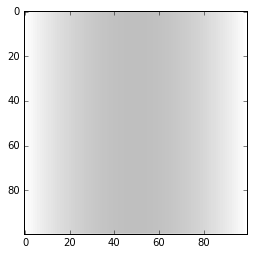

In [516]:
d = np.ones((100, 100, 3), dtype=np.uint8)*255
alpha = np.ones(d.shape[:2], dtype=np.uint8)
#d[:, :, 3] = np.linspace(0, 255, num=100)
alpha[:,:] = np.linspace(0, 255, num=100)
#d[:,:,3] = alpha
dd = np.dstack((d,alpha))
plt.imshow(dd, interpolation='none')
plt.show()

((512, 512), (512, 512, 3), (512, 512, 4))


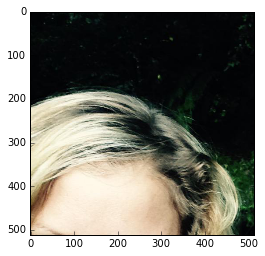

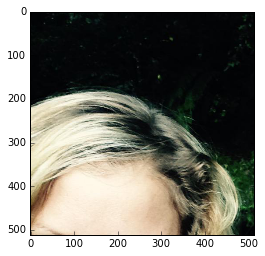

In [520]:
img = imread('jo_patch/jo_pic_000.jpg').astype(np.uint8)
#img = np.ones((100, 100, 3), dtype=np.uint8)*255
alpha = np.ones(img.shape[:2], dtype=np.uint8)*255
#alpha[:,:] = np.linspace(0, 255, num=alpha.shape[1])
print(alpha.shape, img.shape, aimg.shape)
#alpha = np.zeros(img.shape[:2], dtype=np.uint8)
aimg = np.dstack((img, alpha))

plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(aimg)

In [285]:
from skimage.feature import ORB

In [562]:
a = [2, 344, 55, 677, 8, 9, 91, 0,334,35,  33]
num = len(a)-2
print("NUM", num)
for bb in range(num):
    print(a[bb+2])

('NUM', -1)


In [36]:
# use the inverse homography to get the dimensions of the next image
#min_x, min_y, max_x, max_y, move_h, mod_inv_h = findDimensions(bimg, nimg, H)
#img_w = int(math.ceil(max_x))
#img_h = int(math.ceil(max_y))

V12 = np.zeros((bimg.shape[0]+nimg.shape[0], bimg.shape[1] + nimg.shape[1]))
nrgb_warp = cv2.warpPerspective(nrgb, np.linalg.inv(H), V12.shape)
brgb_warp = cv2.warpPerspective(brgb, H, V12.shape)

# Warp the new image given the homography from the old image
#brgb_warp = cv2.warpPerspective(brgb, move_h, (img_w, img_h))
#nrgb_warp = cv2.warpPerspective(nrgb, mod_inv_h, (img_w, img_h))
#brgb_warp = cv2.warpPerspective(brgb, H, (img_w, img_h))
#nrgb_warp = cv2.warpPerspective(nrgb, np.linalg.inv(H), (img_w, img_h))


# Put the base image on an enlarged palette

#enlarged_brgb_img = np.zeros((img_h, img_w,3), np.uint8)
# Now add the warped image

# Create a mask from the warped image for constructing masked composite
(ret,data_map) = cv2.threshold(cv2.cvtColor(nrgb_warp, cv2.COLOR_BGR2GRAY), 
    0, 255, cv2.THRESH_BINARY)

brgb_warp = cv2.add(enlarged_brgb_img, brgb_warp, 
    mask=np.bitwise_not(data_map), 
    dtype=cv2.CV_8U)

In [54]:
V12 = np.zeros((bimg.shape[0]+nimg.shape[0], bimg.shape[1] + nimg.shape[1]))
nrgb_warp = cv2.warpPerspective(nrgb, H, V12.shape)
brgb_warp = cv2.warpPerspective(brgb, H, V12.shape)

In [72]:

matches = match_descriptors(bkk, nkk)


In [79]:
   
src = nkk[matches[:,1]][:,::-1]
dst = bkk[matches[:,0]][:,::-1]
#        model_robust, inliers = ransac((src, dst), ProjectiveTransform,
#                                   min_samples=10, residual_threshold=10,
#                                   stop_sample_num=100, max_trials=300)
#
model_robust, inliers = ransac((src, dst), AffineTransform,
                               min_samples=6, residual_threshold=3,
                               max_trials=100)

ransac_matches = matches[inliers]
inlierRatio = ransac_matches.shape[0]/float(matches.shape[0])
print(inlierRatio)

0.998130841121


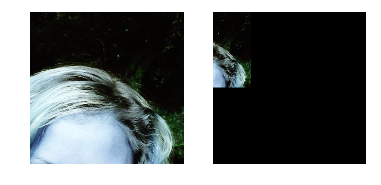

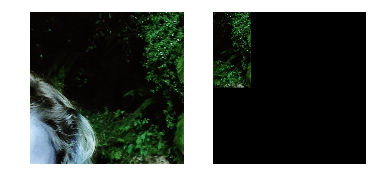

In [55]:
def plot_ba(img1,img2):
    fix, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(img1)
    ax[0].axis('off')
    ax[1].imshow(img2)
    ax[1].axis('off')
plot_ba(brgb, brgb_warp)
plot_ba(nrgb, nrgb_warp)

In [ ]:
plt.imshow(base_warp)

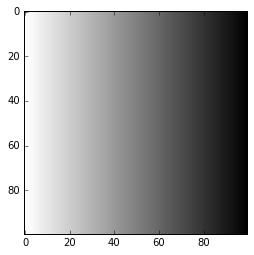

In [234]:
d = np.zeros((100, 100, 4)); 

d[...,-1] = 0
#d[..., -1] = np.linspace(0, 1, num=100)
plt.imshow(d)

In [80]:


base_warp = cv2.cvtColor(brgb_warp, cv2.COLOR_BGR2GRAY)
next_warp = cv2.cvtColor(nrgb_warp, cv2.COLOR_BGR2GRAY)            



#final_img = cv2.add(base_warp, next_warp, 
#                dtype=cv2.CV_8U)
#base_warp[:,:,0][base_warp[:,:,0] == 0] = -1
#next_warp[:,:,0][next_warp[:,:,0] == 0] = -1
# create image masks
#base_mask = np.zeros(base_warp.shape)
#base_mask[base_warp > 0] = 1
#base_warp[~base_mask] = 0
#base_alpha = np.dstack((brgb_warp, base_mask))
#b,g,r = cv2.split(brgb_warp)
#base_alpha = cv2.merge((b,g,r), base_mask)
#next_mask = (next_warp[:,:,0] != -1)
#next_warp[~next_mask] = 0
#next_mask = np.zeros(next_warp.shape)
#next_mask[next_warp > 0] = 1
#b,g,r = cv2.split(nrgb_warp)
#next_alpha = cv2.merge((b,g,r), next_mask)




In [ ]:
mask = np.ones(i.shape[:2])
mask[:, 30:100] = 0
b,g,r = cv2.split(i)
ii = cv2.merge((b,g,r, mask))
#plt.imshow(ii)
ii.shape
#plt.imsave('i.png', ii)

In [ ]:
def blend_imgs(img1, img2):
    

cv::Stitcher is fairly slow. If your cameras definitely don't move relative to one another and the transformation is as simple as you say, you should be able to overlay the images onto a blank canvas simply by chaining homographies.

The following is somewhat mathematical - if this isn't clear I can write it up properly using LaTeX, but SO doesn't support pretty maths :)

You have a set of 4 cameras, from left to right, (C_1, C_2, C_3, C_4), giving a set of 4 images (I_1, I_2, I_3, I_4).

To transform from I_1 to I_2, you have a 3x3 transformation matrix, called a homography. We'll call this H_12. Similarly for I_2 to I_3 we have H_23 and for I_3 to I_4 you'll have H_34.

You can pre-calibrate these homographies in advance using the standard method (point matching between the overlapping cameras).

You'll need to create a blank matrix, to act as the canvas. You can guess the size of this (4*image_size would suffice) or you can take the top-right corner (call this P1_tr) and transform it by the three homographies, giving a new point at the top-right of the panorama, PP_tr (the following assumes that P1_tr has been converted to a matrix):

PP_tr = H_34 * H_23 * H_12 * P1_tr'
What this is doing, is taking P1_tr and transforming it first into camera 2, then from C_2 to C_3 and finally from C_3 to C_4

You'll need to create one of these for combining images 1 and 2, images 1,2 and 3 and finally images 1-4, I'll refer to them as V_12, V_123 and V_1234 respectively.

Use the following to warp the image onto the canvas:

cv::warpAffine(I_2, V_12, H_12, V_12.size( ));
Then do the same with the next images:

cv::warpAffine(I_3, V_123, H_23*H_12, V_123.size( ));
cv::warpAffine(I_4, V_1234, H_34*H_23*H_12, V_1234.size( ));
Now you have four canvases, all of which are the width of the 4 combined images, and with one of the images transformed into the relevant place on each.

All that remains is to merge the transformed images onto eachother. This is easily achieved using regions of interest.

Creating the ROI masks can be done in advance, before frame capture begins.

Start with a blank (zeros) image the same size as your canvases will be. Set the leftmost rectangle the size of I_1 to white. This is the mask for your first image. We'll call it M_1.

Next, to get the mask for the second transformed image, we do

cv::warpAffine(M_1, M_2, H_12, M_1.size( ));
cv::warpAffine(M_2, M_3, H_23*H_12, M_1.size( ));
cv::warpAffine(M_3, M_4, H_34*H_23*H_12, M_1.size( ));
To bring all the images together into one panorama, you do:

cv::Mat pano = zeros(M_1.size( ), CV_8UC3);
I_1.copyTo(pano, M_1);
V_12.copyTo(pano, M_2): 
V_123.copyTo(pano, M_3): 
V_1234.copyTo(pano, M_4): 
What you're doing here is copying the relevant area of each canvas onto the output image, pano - a fast operation.

You should be able to do all this on the GPU, substituting cv::gpu::Mat's for cv::Mats and cv::gpu::warpAffine for its non-GPU counterpart.

shareimprove this answer
edited Apr 1 '15 at 21:07
answered Apr 1 '15 at 20:54

n00dle
3,4631835
